# Hand-on data: Root water uptake from soil moisture measurements

In most settings of environmental studies we are limited in the number of variables and stations to observe the intertwined fluxes of the systems. Therefore, inference from already existing or easy to employ sensors can become highly informative. In many cases, a re-interpretation of observed dynamics is ley to such additional inference. 
This session will present an example on how root water uptake (RWU) can be estimated from precise soil moisture measurements in the rhizosphere. 

For this, we will employ the python package [rootwater](https://pypi.org/project/rootwater/) and compare the inferred RWU to sap flow measurements. This course will refer closely to our recent paper [Jackisch et al.: Estimates of tree root water uptake from soil moisture profile dynamics, Biogeosciences, 2020](https://doi.org/10.5194/bg-17-5787-2020).

*Before we can get started, we have to prepare our working environment by loading some required packages and the examplary data files...*

In [47]:
#load required packages
%pylab inline
import pandas as pd
import numpy as np
import seaborn as sns
import rootwater as rw

#define plotting styles
sns.set_style('whitegrid', {'grid.linestyle': u'--'})
matplotlib.rc('pdf', fonttype=42)
from pandas.plotting import register_matplotlib_converters

#and some more packages we need for the intermediate steps
import scipy.stats as stats
import statsmodels.formula.api as smf 
import scipy.ndimage.filters as spf
import scipy as sp


Populating the interactive namespace from numpy and matplotlib


In [2]:
#load site data of soil water content dynamics (vol.%)
SM = pd.read_csv('soilmoisture.csv',index_col=0)
SM.index = pd.to_datetime(SM.index)

#load sap velocity data (cm/h)
SV = pd.read_csv('sapvelocity.csv',index_col=0)
SV.index = pd.to_datetime(SV.index)

#load cluster precipitation and solar radiation data (mm and W/m2)
prec_rad = pd.read_csv('precip_radiation.csv',index_col=0)
prec_rad.index = pd.to_datetime(prec_rad.index)

#load soil definitions as van Genuchten parameters
VGx = pd.read_csv('vG_RWU.csv',index_col=0).T

*In addition we will need a couple of helper functions and prepared plotting functions. They are defined here:*

In [34]:
#load/define used colour schemes

from palettable.tableau import Tableau_10
from palettable.tableau import Tableau_20
from palettable.cartocolors.qualitative import Bold_8
from palettable.colorbrewer.qualitative import Paired_12

#cm_t10 = plt.cm.get_cmap(Tableau_10.mpl_colormap)
cm_t10 = plt.cm.get_cmap(Bold_8.mpl_colormap)
cm_t20 = plt.cm.get_cmap(Tableau_20.mpl_colormap)

# These are the "Tableau 20" colors as RGB.  
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),  
         (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),  
         (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),  
         (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),  
         (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.  
for i in range(len(tableau20)):  
    r, g, b = tableau20[i]  
    tableau20[i] = (r / 255., g / 255., b / 255.)  

tableau10=tableau20[0::2]


def cumplot(dummy,rain,dpth):
    dummy = dummy.iloc[:,:]-dummy.iloc[0,:]
    dum_sum= dummy.cumsum(axis=1)
    dum2 = dum_sum.iloc[:,0]*0.
    dum2.name='0'
    dum_sum=pd.concat([dum2,dum_sum],axis=1)

    for i in np.arange(len(dpth)):
        if i<10:
            ci=tableau10[i]
        if i>=10:
            ci=tableau20[(i-10)*2+1]
        fill_between(dum_sum.index, dum_sum.iloc[:,i], dum_sum.iloc[:,i+1], color=ci,alpha=0.6,label=dpth[i]+' cm')
        plot(dum_sum.index,dum_sum.iloc[:,i+1],c=ci,alpha=0.8,label='')
                         
    plot(rain, label='Precip')
    ylabel('∆ water (mm)' )
    legend(ncol=2)

    return


## Soil water content

Measurements of soil water content or soil moisture dynamics are commonly done with burried sensors, which use the strong contrast of the electric properties of water compared to the mineral soil phase and air. The physical property behind the principle is the [relative electric permittivity](https://en.wikipedia.org/wiki/Relative_permittivity). Since air ranges at the value of 1, mineral soil between 3 and 5, and water arround 70; it is mostly water which changes the capacitance of the bulk soil as capacitor and which changes the permitivity of the bulk soil for electromagnetic wave propagation. The different measurement techniques exploit this strong effect.

However, one should be always aware that these measurement principles have strong limits and can be affected by temperature, solutes, organic compounds and mechanical issues like corrosion and contact of the probe. For more background information about this, you can start your research with my paper in ESSD [Jackisch et al.: Soil moisture and matric potential – an open field comparison of sensor systems, 2020](https://essd.copernicus.org/articles/12/683/2020/).

For our example, we have used a TDR tube probe sensor, which was installed in the rhizosphere of beech trees in Luxembourg, central Europe. We have records of soil moisture every 30 minutes in 20 cm thick soil layers. The data set origins from a sandy site and a site with silty loess deposits on a gravely slate bedrock. Both sites are very close to each other and experience almost identical weather.

**Let us explore this data:**

In [3]:
#soil moisture data
SM.head()

,Sand_SM_10,Sand_SM_30,Sand_SM_50,Sand_SM_70,Sand_SM_90,Sand_SM_110,Sand_SM_130,Sand_SM_150,Sand_SM_170,Sand_SM_190,...,Sand_SM_230,Slate_SM_10,Slate_SM_30,Slate_SM_50,Slate_SM_70,Slate_SM_90,Slate_SM_110,Slate_SM_130,Slate_SM_150,Slate_SM_170
2017-04-05 12:00:00,12.510,9.160,16.695,20.745,23.275,27.895,25.340,27.790,14.305,14.910,...,16.225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-05 12:30:00,12.515,9.165,16.705,20.750,23.275,27.895,25.335,27.795,14.315,14.910,...,16.225,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-05 13:00:00,12.520,9.170,16.710,20.750,23.285,27.895,25.310,27.770,14.310,14.910,...,16.215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-05 13:30:00,12.535,9.180,16.720,20.745,23.270,27.895,25.315,27.800,14.305,14.885,...,16.220,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-04-05 14:00:00,12.540,9.180,16.710,20.760,23.270,27.895,25.330,27.785,14.305,14.900,...,16.215,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [32]:
#precipitation and radiation data
prec_rad.head()

,Sand_Precip,Slate_Precip,Rad
TIMESTAMP,,,
2017-04-05 00:50:00,0.0,0.0,0.81
2017-04-05 01:50:00,0.0,0.0,0.81
2017-04-05 02:50:00,0.0,0.0,0.81
2017-04-05 03:50:00,0.0,0.0,0.81
2017-04-05 04:50:00,0.0,0.0,0.81


Text(0.5, 1.0, 'Precipitation and Soil Moisture in 30 cm Depth')

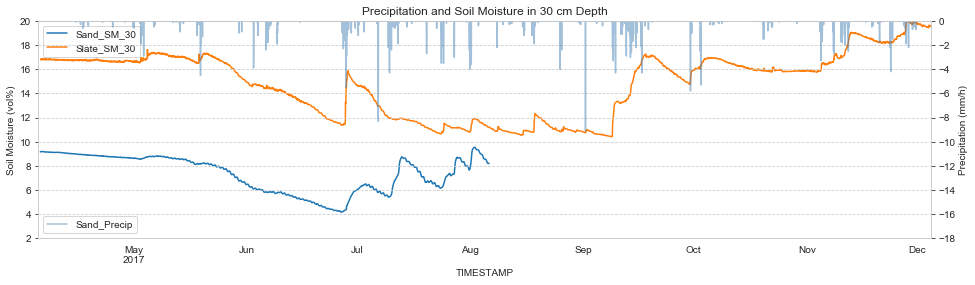

In [31]:
figsize(16,4)
SM.Sand_SM_30.resample('1h').mean().plot()
SM.Slate_SM_30.resample('1h').mean().plot()
ylabel('Soil Moisture (vol%)')
ylim(2,20)
legend(loc=4)
(-1.*prec_rad.Sand_Precip).resample('1h').mean().plot(secondary_y=True,c='steelblue',alpha=0.5)
ylabel('Precipitation (mm/h)')
ylim(-18,0)
legend()
title('Precipitation and Soil Moisture in 30 cm Depth')

This appears rather as to be expected: In dry summer spells (June) soil moisture decreases and becomes (partially) refilled in a storm event on July 1. It takes until the onset of the more cold and wet autumn in late September to increase soil moisture.

## How does soil moisture change during an event?
Since we have data for a full soil profile through the rhizosphere, we have the opportunity to analyse the reaction of this soil to a storm event more closely. We take the storm on August 1 as an example. Here, we have converted the change in soil moisture to absolute mm of water in each layer.

Soil moisture or volumetric soil water content is defined as the volumetric proportion of a bulk soil, which is filled with water. Hence a soil layer with 200 mm will contain 2 mm of water per percent of soil moisture. Sometimes it appears mind twisting to convert volumes and fluxes to such length of water column. Just imagine that you have a volume which requires to be normalised by the area anyway. If 1 L of water (=0.001 m³) is applied to 1 m² this converts to 1 mm.

Text(0.5, 0, 'Date')

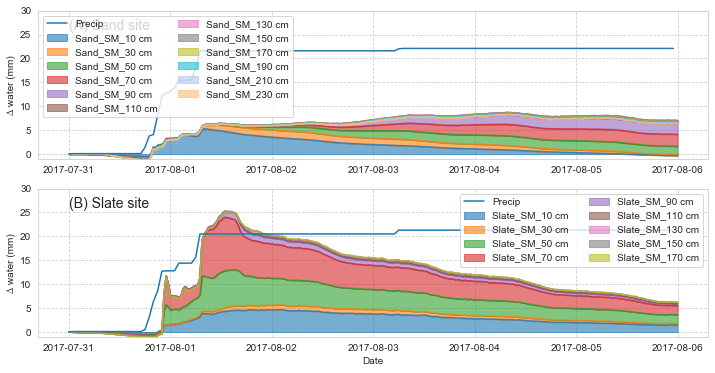

In [39]:
t_start = pd.to_datetime('2017-07-31')
t_end = pd.to_datetime('2017-8-6')

figsize(12,6)

subplot(211)
dpth = ['Sand_SM_10', 'Sand_SM_30', 'Sand_SM_50', 'Sand_SM_70', 'Sand_SM_90',
       'Sand_SM_110', 'Sand_SM_130', 'Sand_SM_150', 'Sand_SM_170',
       'Sand_SM_190', 'Sand_SM_210', 'Sand_SM_230']
cumplot(SM.loc[t_start:t_end,dpth],prec_rad.loc[t_start:t_end,'Sand_Precip'].resample('1h').max().cumsum(),dpth)
text(t_start,26,'(A) Sand site',fontsize=14)
ylim([-1,30])
#legend(loc=1,ncol=3)
#xticklabel('')
#title('Sandstone site')

subplot(212)
dpth = ['Slate_SM_10', 'Slate_SM_30', 'Slate_SM_50', 'Slate_SM_70', 'Slate_SM_90',
       'Slate_SM_110', 'Slate_SM_130', 'Slate_SM_150', 'Slate_SM_170']
cumplot(SM.loc[t_start:t_end,dpth],prec_rad.loc[t_start:t_end,'Slate_Precip'].resample('1h').max().cumsum(),dpth)
text(t_start,26,'(B) Slate site',fontsize=14)
ylim([-1,30])
xlabel('Date')
#legend(loc=1,ncol=3)
#title('Slate site')

#savefig('WB_0817x.pdf',bbox_inches='tight')

Let us interpret what we are seeing here:

A very similar event causes a very different reaction in the soil water dynamics at the two sites. Over all after 5 days, the total remaining water from the event is almost the same. However, the distributions over the profiles differ substantially.

In the **sandy soil** (top figure), the soil layers react one after another. Water enters the soil and is registered in the top layer, then causing an increase of soil moisture in the second layer and so on. The water is percolation through the soil eventually filling the stores in 50 to 90 cm depth.

In the **slate site soil** (bottom figure), we registered a very strong reaction simultaneously in 10, 50 and 70 cm depth. There is almost no percolation present. The initially strong reaction is depleted in the three layers in parallel. This speaks for a highly structured soil with macropores dominating the system.

## Soil moisture is not only about stores filling and emptying
... or at least the filling and emptying is giving much more insight than only some water stock.

Let us look at times, the trees are most active – sufficient supplies, radiation makes the photosynthesis engine roar...

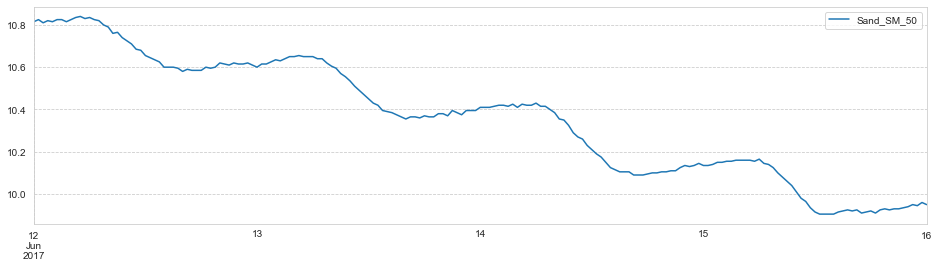

In [46]:
t_start = pd.to_datetime('2017-06-12')
t_end = pd.to_datetime('2017-06-16')

figsize(16,4)
SM.loc[t_start:t_end,['Sand_SM_50']].plot()
#SM.loc[t_start:t_end,['Slate_SM_50', 'Slate_SM_70']].plot()


This figure shows how soil moisture decreases each day in a step-wise manner. An the decrease is actually taking place in a couple of hours each day while during 2/3 there is some sort of depletion of the draft.

We will explore this more closely...

To get there, we make use of the package astral to calculate the times for sunrise/sunset for our location. We include the observed radiation for reference. We convert the observed soil moisture into change of soil moisture (here negative change is plotted as positive). And we take observed sap velocity (xylem water flow) as further reference.

In [53]:
#get sunrise/sunset from astral (included in rwu function)
from astral import LocationInfo
from astral.sun import sun

l = LocationInfo()
l.latitude = 49.70764
l.longitude = 5.897638
l.timezone = 'Etc/GMT-1'
l.elevation = 200

#sunrise sunset
def sunr(dd):
    # give date and return time of sunrise
    sunrise = pd.to_datetime(sun(l,date=dd)['sunrise'])
    return sunrise
    
def suns(dd):
    # give date and return time of sunset
    sunset = pd.to_datetime(sun(l,date=dd)['sunset'])
    return sunset

([<matplotlib.axis.XTick at 0x7fa7eb2239b0>,
 <a list of 9 Text xticklabel objects>)

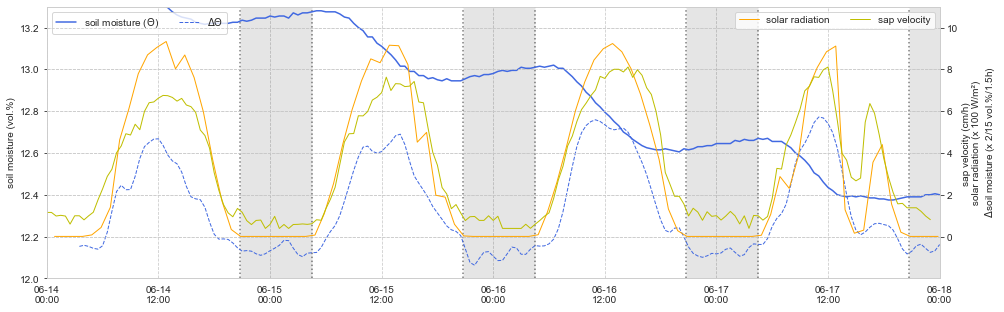

In [55]:
figsize(16,5)
t_start = pd.to_datetime('2017-06-12')
t_end = pd.to_datetime('2017-06-16')

soil=SM.loc[t_start:t_end,'Sand_SM_70']
ray=prec_rad.loc[t_start:t_end,'Rad']/100
saps=SV.loc[t_start:t_end,'Sand_SV_inner']
saps = saps.tz_localize('Etc/GMT-1')

dif_ts = pd.Series(spf.gaussian_filter1d(soil.diff(3),1))
dif_ts.index = soil.index

fig, ax1 = plt.subplots()
ax1.plot(soil.index,soil,c='royalblue',linestyle='-',label='soil moisture ($\Theta$)')
ax1.plot(dif_ts.index,-7.5*(dif_ts)+12.2,c='royalblue',linestyle='--',lw=1,label='$\Delta \Theta$')
ax1.set_ylabel('soil moisture (vol.%)')
ax1.set_ylim([12.,13.3])
ax1.set_xlim([t_start,t_end])

#dates to consider:
ddx = soil.resample('1d').mean().index.date

for i in np.arange(len(ddx)):
    sus = pd.to_datetime(sun(l,date=ddx[i])['sunset'])+datetime.timedelta(hours=1)
    sur = pd.to_datetime(sun(l,date=ddx[i]+datetime.timedelta(hours=24))['sunrise'])+datetime.timedelta(hours=1)
    ax1.vlines(sus,12.,13.3,'k',':',alpha=0.5)
    ax1.vlines(sur,12.,13.3,'k',':',alpha=0.5)
    if i == len(ddx)-1:
        ax1.fill_betweenx([12.,13.3],[sus,sus],[sur,sur],facecolor='k',alpha=0.1)#,label='astron. night')
    else:
        ax1.fill_betweenx([12.,13.3],[sus,sus],[sur,sur],facecolor='k',alpha=0.1)
        
ax1.legend(loc=2,ncol=2)
ax2 = ax1.twinx()
yticks(np.arange(0,17,2),np.arange(0,17,2))
leg2,=ax2.plot(ray.index,ray,c='orange',linestyle='-',lw=1,label='solar radiation')
leg3,=ax2.plot(saps.index,saps,c='y',linestyle='-',lw=1,label='sap velocity')
ax2.set_ylabel('sap velocity (cm/h) \n solar radiation (x 100 W/m²) \n $-\Delta$soil moisture (x 2/15 vol.%/1.5h)')

ax2.set_ylim([-2,11])
ax2.legend([leg2,leg3,],['solar radiation','sap velocity'],loc=1,ncol=2)
ax2.set_xlim([t_start,t_end])

xticks(SM.loc[t_start:t_end].resample('12h').mean().index,['06-14\n00:00','06-14\n12:00','06-15\n00:00','06-15\n12:00','06-16\n00:00','06-16\n12:00','06-17\n00:00','06-17\n12:00','06-18\n00:00'])
#



By deriving the change in soil moisture, we get a nice diurnal signal which obviously strongly correlates with solar radiation and sap velocity.
